# Prewhitening

Vamos a ver como hacer prewhitening de varias series.

Un link interesante sobre [prewhitening](https://onlinecourses.science.psu.edu/stat510/node/75). Y otro [más](http://support.sas.com/documentation/cdl/en/etsug/60372/HTML/default/viewer.htm#etsug_arima_sect033.htm)

Básicamente, si tenemos $X$ e $Y$ dos series de tiempo, la función de correlación cruzada (CCF) se ve afectada tanto por la estructura interna de ambas series, su autocorrelación, así como también las tendencias compartidas que puedan tener.

Para mitigar este problema, se efectúa un proceso llamado "prewhitening", que consta de las siguientes etapas

1. Determinar un modelo para la variable $X$ y guardar los residuos de dicho modelo
2. Filtrar la variable $Y$ con el modelo planteado en el paso 1
3. Examinar la correlación cruzada entre los residuos de $X$ e $Y$. 

En el paso 1, casi siempre vamos a filtrar hacia un modelo de tipo ARIMA (Autoregressive Integrated Moving Average). Los modelos ARIMA tienen parámetros $p, d, q$



- p: Orden del modelo autoregresivo
- d: Orden de la integración (cuantas veces lo diferencié para lograr la estacionariedad)
- q: Orden del promedio móvil

En nuestro caso, los modelos que nos interesan fittear son $ARIMA(1, 0, 0)$, o sea, autoregresivos de orden 1.


Creemos una serie de tiempo autoregresiva de órden 1.


In [1]:
%matplotlib inline
import os
os.chdir("../..")


import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import plot_autocorrelations, plot_cross_correlogram
from tsa import autoregressive, autocorrelogram

pylab.rcParams['figure.figsize'] = (18,4)



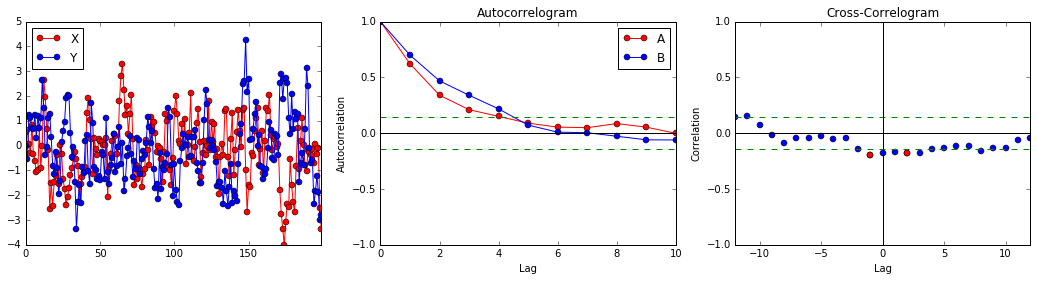

In [2]:

alpha = 0.65
n = 200

Z1 = pd.Series(np.random.randn(n))
Z2 = pd.Series(np.random.randn(n))
X = autoregressive(Z1, alpha)
Y = autoregressive(Z2, alpha)

f, ax = plt.subplots(ncols=3)

pd.DataFrame({'X': X, 'Y': Y}).plot(color=['r', 'b'], style='-o', ax=ax[0])
plot_autocorrelations(X, Y, ax=ax[1])
plot_cross_correlogram(X, Y, "", ax=ax[2], max_lag=12)


Un buen estimador para el $\alpha$ de un proceso AR(1) es $r_1$, es decir, la autocorrelación con lag 1. (Ver Chatfield, sección 4.2)

\begin{align}
\hat{\alpha} = r_1 \\
\end{align}


In [3]:
acf = autocorrelogram(X)


print acf[1]

0.621889100409


Recordemos que nuestro proceso es de la forma $X_t = c + \alpha X_{t-1} + \epsilon_t$. Si $|\alpha| < 1$, el proceso es fuertemente estacionario. Asumiendo ésto, y tomando esperanza de ambos lados:

\begin{align}
E[X_t] &= E[c] + \alpha E[X_{t-1}] + E[ \epsilon_{t} ] \\
E[X_t] &= c + \alpha E[X_{t-1}] \tag*{Ya que $\epsilon_t$ es ruido blanco} \\
E[X_t] - \alpha E[X_{t-1}] &= c \\
(1 - \alpha) E[X_t] &= c \tag*{Ya que es estacionaria $\rightarrow$ tienen esperanza constante} \\ 
E[X_t] &= \frac{c}{1-\alpha}
\end{align}

Luego, si tomamos que $\bar{X} \simeq \frac{c}{1-\alpha}$, puede verse que

\begin{align}
\epsilon_t \simeq (X_t - \bar{X})  - \alpha (X_{t-1} - \bar{X})\\
\end{align}

Utilicemos esta ecuación para filtrar la serie X

In [4]:
from tsa import autoregressive_prewhitening

rX, rY = autoregressive_prewhitening(X, Y)

Veamos, como era esperable, que el correlograma cruzado arroja valor significativo alguno, ya que ambas series eran "independientes"

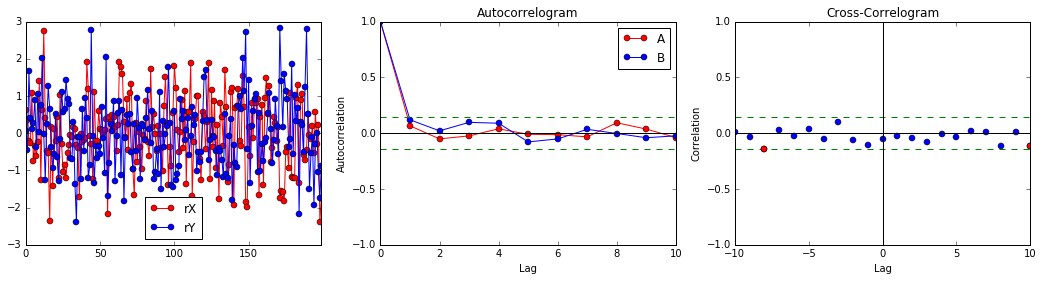

In [5]:

f, ax = plt.subplots(ncols=3)

pd.DataFrame({'rX': rX, 'rY': rY}).plot(color=['r', 'b'], style='-o', ax=ax[0])
plot_autocorrelations(rX, rY, ax=ax[1])
plot_cross_correlogram(rX, rY, "", ax=ax[2], max_lag=10)

In [6]:
print pd.DataFrame({'X': X, 'rX': rX, 'Z': Z1})

print rX.corr(Z1)

            X         Z        rX
0    0.535865  0.535865  0.614193
1    0.609852  0.609852  0.354932
2    0.081710 -0.314693 -0.219222
3   -0.293541 -0.346653 -0.266028
4    0.817983  1.008784  1.078861
5   -0.328301 -0.859989 -0.758667
6   -0.619166 -0.405771 -0.336671
7   -1.079103 -0.676645 -0.615722
8   -0.989806 -0.288389 -0.240396
9    0.710436  1.353810  1.404314
10  -0.902732 -1.364515 -1.266216
11  -0.017789  0.568987  0.621939
12   2.646380  2.657943  2.735771
13   1.979729  0.259582  0.412302
14   0.674940 -0.611884 -0.477904
15  -0.191718 -0.630428 -0.533127
16  -2.545078 -2.420461 -2.347522
17  -1.497948  0.156353  0.163137
18  -2.426291 -1.452625 -1.416405
19  -1.485444  0.091645  0.101768
20  -1.216616 -0.251078 -0.214507
21  -0.397771  0.393029  0.437157
22  -1.531146 -1.272595 -1.205448
23   0.004294  0.999539  1.034825
24  -0.352730 -0.355521 -0.277072
25  -1.329410 -1.100135 -1.031722
26  -1.752765 -0.888649 -0.847691
27  -2.382631 -1.243334 -1.214277
28  -2.087791 